# Automatic relevance determination (ARD)

Author: [Zeel B Patel](https://patel-zeel.github.io/)

In [1]:
import scipy.stats
import GPy
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

rc('text', usetex=True)
rc('font', size=16)

To understand the concept of ARD, let us generate a symthetic dataset where all features are not equally important.

In [2]:
np.random.seed(0)
N = 400
X = np.empty((N, 3))
y = np.empty((N, 1))

cov = [[1,0,0,0.99],[0,1,0,0.6],[0,0,1,0.1],[0.99,0.6,0.1,1]]

samples = np.random.multivariate_normal(np.zeros(4), cov, size=N)

X[:,:] = samples[:,:3]
y[:,:] = samples[:,3:4]
print('Correlation between X1 and y', np.corrcoef(X[:,0], y.ravel())[1,0])
print('Correlation between X2 and y', np.corrcoef(X[:,1], y.ravel())[1,0])
print('Correlation between X3 and y', np.corrcoef(X[:,2], y.ravel())[1,0])

Correlation between X1 and y 0.7424364387053712
Correlation between X2 and y 0.4771760788020134
Correlation between X3 and y 0.07463999808005005


Let us fit a GP model with a common lengthscale for all features.

In [3]:
model = GPy.models.GPRegression(X, y, GPy.kern.RBF(input_dim=3, ARD=False))
model.optimize()
model

GP_regression.,value,constraints,priors
rbf.variance,111.47290536431103,+ve,
rbf.lengthscale,26.862865061479035,+ve,
Gaussian_noise.variance,0.3083839240873474,+ve,


Visualizing fit over $X_1$

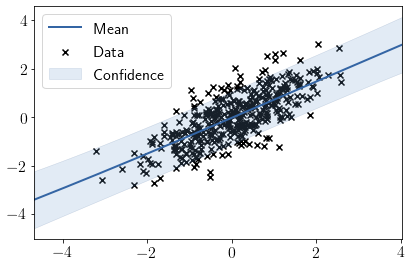

In [4]:
model.plot(visible_dims=[0]);

Visualizing fit over $X_3$

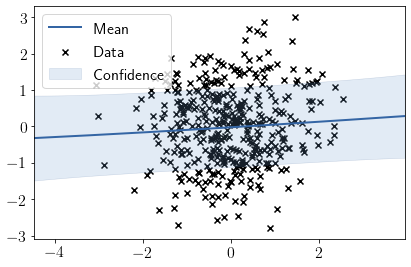

In [5]:
model.plot(visible_dims=[2]);

Now, let us turn on the ARD and see the values of lengthscales learnt.

In [6]:
model = GPy.models.GPRegression(X, y, GPy.kern.RBF(input_dim=3, ARD=True))
model.optimize()
model.kern.lengthscale

index,GP_regression.rbf.lengthscale,constraints,priors
[0],22.24437029,+ve,
[1],33.16175836,+ve,
[2],143.39745522,+ve,


We can see that the lengthscale for $X_3$ is abnormally larger than the other two due to lowest correlation with data.

## Real-data

Let us try a real dataset and see what insights we can get by ARD experiment on it.

In [7]:
from sklearn.datasets import load_boston

In [8]:
X, y = load_boston(return_X_y=True)
y = y.reshape(-1,1)
X.shape, y.shape

((506, 13), (506, 1))

Let us see what do we get from ARD enabled GP fit.

In [9]:
model = GPy.models.GPRegression(X, y, GPy.kern.RBF(input_dim=13, ARD=True))
model.optimize()
model.kern.lengthscale

index,GP_regression.rbf.lengthscale,constraints,priors
[0],288.47316598,+ve,
[1],1958.66785662,+ve,
[2],96.63008923,+ve,
[3],522.58028671,+ve,
[4],262.09440505,+ve,
[5],3.15337665,+ve,
[6],267.59752767,+ve,
[7],2.07260971,+ve,
[8],154.25307337,+ve,
[9],218.28124322,+ve,


We can see some features seem more important (e.g. `[5],[7]`) and others do not. Let us verify this visually.

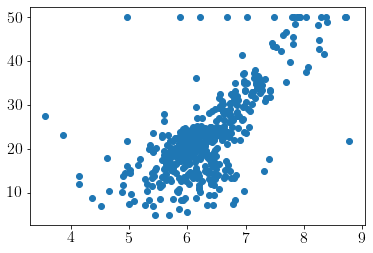

In [10]:
plt.scatter(X[:,5], y);

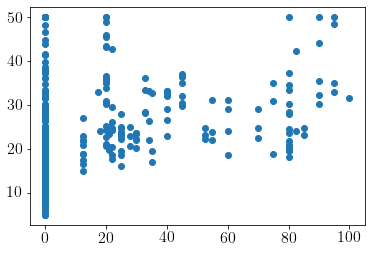

In [11]:
plt.scatter(X[:,1], y);

We can see a strong patern in `[5]` but we can not see any patterns in `[1]`.